In [1]:
import numpy as np

# start by making some random data, say 1000 series that are all 24-elments

# we will use numpy's random number generator to add some noise
rng = np.random.default_rng(12345)


# if we think of these as each series being an "observation" and each element being a "feature" we can make a 2d array
nobs = 1000
nfeatures = 24
mat = np.zeros((nobs, nfeatures))

# in each row, we might expect to find one of a small number of patterns.
# For this synthetic example, let's provide those patterns:
def pattern_a(data):
    # pure noise
    return rng.uniform(0, 1, len(data))

def pattern_b(data, phase=None):
    # clipped sin wave with slightly random phase and amplitude
    if phase is None:
        phase = rng.uniform( np.pi, 2*np.pi ) # in radians
    amplitude = rng.normal()
    time = np.linspace(0, 2*np.pi, len(data))
    wave = amplitude * np.sin(time + phase)
    wave = np.where(wave<0, 0.0, wave)
    return wave

def pattern_c(data):
    # maybe two peaks
    wave1 = pattern_b(data)
    wave2 = pattern_b(data)
    return (wave1 + wave2)/2

def get_pattern(data):
    choice = rng.integers(low=0, high=3)
    if choice == 1:
        patt = pattern_a(data)
    elif choice == 2:
        patt = pattern_b(data, phase=rng.uniform( 0, np.pi/4))
    else:
        patt = pattern_c(data)
    return patt

def add_noise(data):
    noise = rng.uniform(-0.4, 0.4, len(data))
    added = data + noise
    added = np.where(added < 0, 0.0, added)
    return added

In [2]:
# https://towardsdatascience.com/how-to-apply-hierarchical-clustering-to-time-series-a5fe2a7d8447

from sktime.distances.elastic_cython import dtw_distance
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram




In [3]:
import matplotlib.pyplot as plt

In [4]:

def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(dist_mat)
    if method == 'single':
        Z = single(dist_mat)
    if method == 'average':
        Z = average(dist_mat)
    if method == 'ward':
        Z = ward(dist_mat)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    
    return Z

Text(0.5, 1.0, 'MAX: 1.0001751635504599')

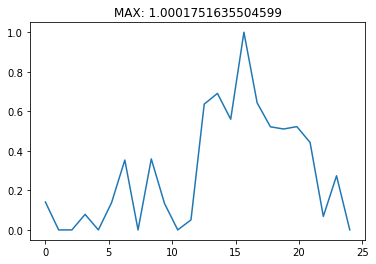

In [5]:
p = add_noise(get_pattern(np.zeros(24)))
plt.plot(np.linspace(0,24,24), p)
plt.title(f"MAX: {p.max().item()}")

In [6]:
# now fill our matrix with patterns
for i in range(nobs):
    mat[i,:] = add_noise(get_pattern(np.zeros(nfeatures)))


In [7]:
mat.shape

(1000, 24)

In [8]:
%%time
distance_matrix = np.zeros(shape=(nobs, nobs))
# Build distance matrix
for i in range(nobs):
    x = np.expand_dims(mat[i,:],axis=-1)
    for j in range(nobs):
        y = np.expand_dims(mat[j,:],axis=-1)
        if i != j:
            dist = dtw_distance(x, y)
            distance_matrix[i, j] = dist

CPU times: user 31.8 s, sys: 376 ms, total: 32.2 s
Wall time: 35.1 s


In [9]:
distance_matrix

array([[0.        , 1.27309243, 1.80940302, ..., 0.61789174, 1.88096803,
        2.26710101],
       [1.27309243, 0.        , 2.97688353, ..., 1.29341317, 3.70001898,
        2.63412477],
       [1.80940302, 2.97688353, 0.        , ..., 1.86680918, 2.24847492,
        1.14712872],
       ...,
       [0.61789174, 1.29341317, 1.86680918, ..., 0.        , 1.96915897,
        1.9359152 ],
       [1.88096803, 3.70001898, 2.24847492, ..., 1.96915897, 0.        ,
        2.5170345 ],
       [2.26710101, 2.63412477, 1.14712872, ..., 1.9359152 , 2.5170345 ,
        0.        ]])

/Users/brianpm/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:364: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


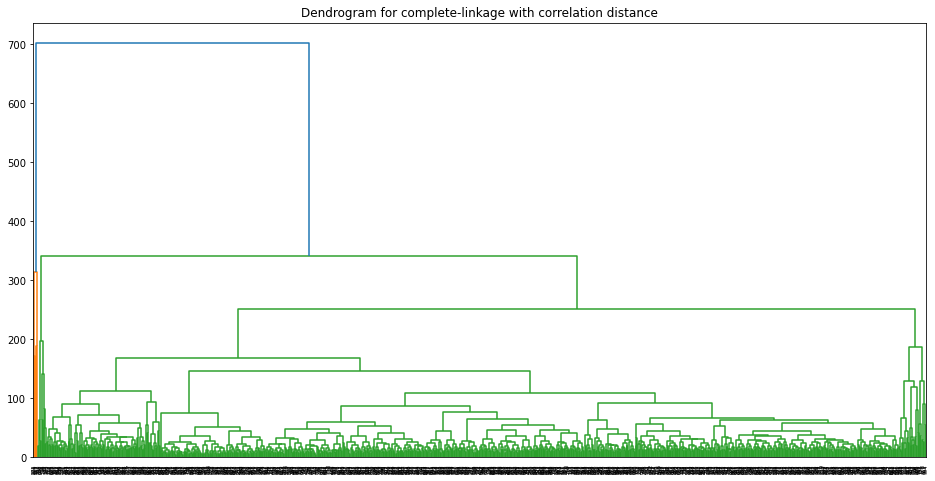

CPU times: user 16.8 s, sys: 1.18 s, total: 18 s
Wall time: 19 s


In [10]:
%%time
linkage_matrix = hierarchical_clustering(distance_matrix)

(max clusters 2) We get 2 clusters
(max clusters 4) We get 4 clusters
(max clusters 8) We get 8 clusters


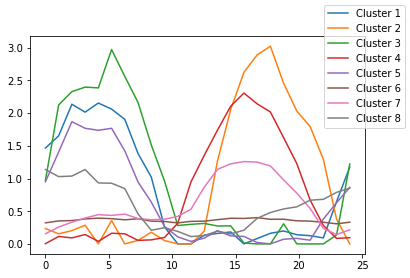

In [11]:
from scipy.cluster.hierarchy import fcluster

# Two ways to get clusters

# select maximum number of clusters
MxClusters = [2, 4, 8]
for mx in MxClusters:
    cluster_labels = fcluster(linkage_matrix, mx, criterion='maxclust')
    print(f"(max clusters {mx}) We get {len(np.unique(cluster_labels))} clusters")

# construct composite clusters
cLabels = np.unique(cluster_labels)
nClusters = len(cLabels)
cl = {}
for i in cLabels:
    cl[i] = mat[np.where(cluster_labels==i), :].mean(axis=1).squeeze()

fig, ax = plt.subplots()
for i in cLabels:
    ax.plot(np.linspace(0,24,24), cl[i], label=f'Cluster {i}')
fig.legend()    



In [12]:

# hand-select an appropriate cut-off on the dendrogram
cluster_labels = fcluster(linkage_matrix, 200, criterion='distance')
print(f"We get {len(np.unique(cluster_labels))} clusters")
#>> 3 unique clusters
cluster_labels = fcluster(linkage_matrix, 300, criterion='distance')
print(f"We get {len(np.unique(cluster_labels))} clusters")
#>> 2 unique clusters

We get 5 clusters
We get 4 clusters


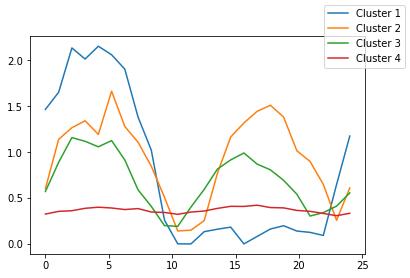

In [13]:
# construct composite clusters
cLabels = np.unique(cluster_labels)
nClusters = len(cLabels)
cl = {}
for i in cLabels:
    cl[i] = mat[np.where(cluster_labels==i), :].mean(axis=1).squeeze()

fig, ax = plt.subplots()
for i in cLabels:
    ax.plot(np.linspace(0,24,24), cl[i], label=f'Cluster {i}')
fig.legend()    
